## <center><ins>Trabajo Práctico 1: Reservas de hotel</ins></center>
#### <center>*Checkpoint 3: Ensambles - SVM*</center>
##### <center>75.06 / 95.58 Organización de Datos - FIUBA</center>
##### <center>Ing. Rodríguez - 1°C 2023</center>
---
#### <center>**Grupo 31 - "Datazo":**</center>
<center> Michael Mena - 102685</center>
<center>Pablo Brocca - 104256</center>
<center>Diego Kisinovsky - 106203</center>

---
---

## Carga de datos y librerías

##### Imports:

In [1]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

# Modelos y métricas
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from six import StringIO

# Preprocesamiento
from sklearn.preprocessing import MinMaxScaler

# Manejo de modelos
from pickle import dump
from pickle import load

# Configuración de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# SVM
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


##### Lectura del dataset preprocesado:

In [2]:
hotel_train = pd.read_csv('./dataset/hotels_train_preprocesado.csv')

---

## Armado y entrenamiento del modelo

##### Preparación de features:

In [3]:
features = hotel_train.drop(['is_canceled'],axis=1).columns
          
target = 'is_canceled'

features.tolist()

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests',
 'room_type_unchanged',
 'country_encoded',
 'customer_type_Group',
 'customer_type_Transient',
 'customer_type_Transient-Party',
 'deposit_type_Non Refund',
 'deposit_type_Refundable',
 'hotel_Resort Hotel',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA/TO',
 'distribution_channel_Undefined',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline TA/TO',
 'market_segment_Online TA',
 'market_segment_Undefined',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined']

In [4]:
cols_categorical = ['room_type_unchanged',
                    'country_encoded',
                   'customer_type_Group',
                   'customer_type_Transient',
                   'customer_type_Transient-Party',
                   'deposit_type_Non Refund',
                   'deposit_type_Refundable',
                   'hotel_Resort Hotel',
                   'distribution_channel_Direct',
                   'distribution_channel_GDS',
                   'distribution_channel_TA/TO',
                   'distribution_channel_Undefined',
                   'market_segment_Complementary',
                   'market_segment_Corporate',
                   'market_segment_Direct',
                   'market_segment_Groups',
                   'market_segment_Offline TA/TO',
                   'market_segment_Online TA',
                   'market_segment_Undefined',
                   'meal_FB',
                   'meal_HB',
                   'meal_SC',
                   'meal_Undefined']

In [5]:
cols_to_normalize =[col for col in hotel_train.columns if col not in cols_categorical]

In [6]:
cols_to_normalize.remove('is_canceled')
cols_to_normalize

['lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'stays_in_nights',
 'total_of_guests']

#### Definicion de funcion metricas:

In [7]:
def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

### Train-Test Split:

In [8]:
# Separamos un 20% de los datos para test
x_train, x_test, y_train, y_test = train_test_split(hotel_train[features].values, 
                                                    hotel_train[target].values, 
                                                    test_size=0.2,    
                                                    random_state=42,  
                                                    stratify=hotel_train[target].values) 

# Verificamos cantidad de datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

# Verificamos como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

# Datos Entrenamiento: 48682
# Datos Prueba: 12171
% Positivos Entrenamiento: 50.433
% Positivos Prueba: 50.431


## Análisis del modelo SVM

#### Versión con MinMaxScaler: $\frac{x_i - \min(x)}{\max(x) - \min(x)}$

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train) 
x_test_minmax  = min_max_scaler.transform(x_test) 

#### Versión estandarizada: $\frac{x_i - mean(x)}{stdev(x)}$

In [9]:
x_train_to_norm = pd.DataFrame(x_train, columns=features).drop(cols_categorical, axis=1)
x_test_to_norm = pd.DataFrame(x_test, columns=features).drop(cols_categorical, axis=1)

In [12]:
x_train_categorical = pd.DataFrame(x_train, columns=features).drop(cols_to_normalize, axis=1)
x_test_categorical = pd.DataFrame(x_test, columns=features).drop(cols_to_normalize, axis=1)

In [13]:
# stand_scaler = preprocessing.StandardScaler()
# x_train_norm = stand_scaler.fit_transform(x_train)
# x_test_norm=stand_scaler.transform(x_test)

# Aplicar la transformación de escalado de características solo a las columnas seleccionadas
stand_scaler = preprocessing.StandardScaler()
x_train_norm_scaled = stand_scaler.fit_transform(x_train_to_norm)
x_test_norm_scaled = stand_scaler.transform(x_test_to_norm)

# Convertir las matrices escaladas nuevamente en DataFrames
x_train_norm_scaled = pd.DataFrame(x_train_norm_scaled, columns=cols_to_normalize)
x_test_norm_scaled = pd.DataFrame(x_test_norm_scaled, columns=cols_to_normalize)

# Agregar las columnas categoricas a las matrices escaladas
x_train_norm = pd.concat([x_train_norm_scaled, x_train_categorical], axis=1)
x_test_norm = pd.concat([x_test_norm_scaled, x_test_categorical], axis=1)

#### Entreno el modelo

##### Datos sin normalizar

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      6033
           1       0.64      0.53      0.58      6138

    accuracy                           0.61     12171
   macro avg       0.62      0.61      0.61     12171
weighted avg       0.62      0.61      0.61     12171



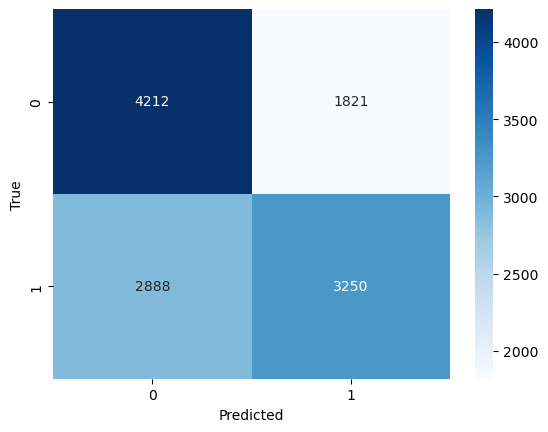

In [13]:
#Construyo un modelo SVM  
svm = SVC()

#Lo entreno con los datos sin escalar
svm.fit(x_train, y_train)

#Hago la prediccion y calculo las métricas
y_pred=svm.predict(x_test)
metricas(y_pred,y_test)

##### Datos normalizados con StandardScaler

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      6033
           1       0.85      0.84      0.85      6138

    accuracy                           0.84     12171
   macro avg       0.84      0.84      0.84     12171
weighted avg       0.84      0.84      0.84     12171



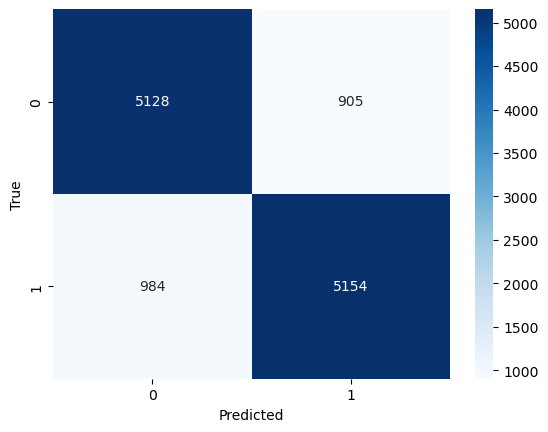

In [14]:
#Construyo un modelo SVM  
svm_norm= SVC()

#Lo entreno con los datos escalados con normalizacion
svm_norm.fit(x_train_norm, y_train)

#Hago la prediccion y calculo las métricas
y_pred_norm=svm_norm.predict(x_test_norm)
metricas(y_pred_norm,y_test)

In [15]:
accuracy_svm_norm = accuracy_score(y_test, y_pred_norm)*100
print(f'Accuracy: {accuracy_svm_norm:.2f}%')

Accuracy: 84.48%


##### Datos normalizados con MinMaxScaler

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      6033
           1       0.82      0.84      0.83      6138

    accuracy                           0.83     12171
   macro avg       0.83      0.83      0.83     12171
weighted avg       0.83      0.83      0.83     12171



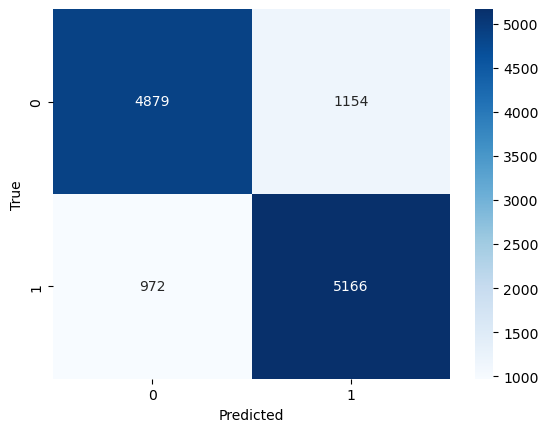

In [16]:
#Construyo un modelo SVM  
svm_minmax= SVC()

#Lo entreno con los datos escalados con min max
svm_minmax.fit(x_train_minmax, y_train)

#Hago la prediccion y calculo las métricas
y_pred_minmax=svm_minmax.predict(x_test_minmax)
metricas(y_pred_minmax,y_test)

### SVM + PCA

#### Analisis componentes principales

El número de componentes necesarios para retener el 90.0% de varianza explicada es 15.


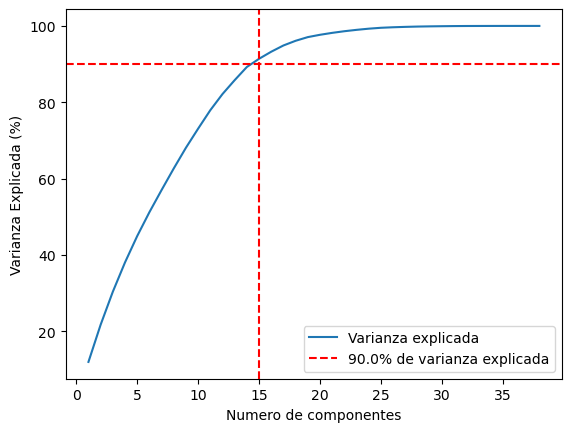

In [46]:
# # Escalar los datos de entrenamiento
# sc = StandardScaler()
# x_train_scaled = sc.fit_transform(x_train)

# PCA sobre los datos escalados
pca = PCA(n_components=None)
pca.fit(x_train_norm)

# Graficar la Varianza Explicada
n_componentes = len(pca.explained_variance_ratio_)
plt.plot(range(1, n_componentes + 1), np.cumsum(pca.explained_variance_ratio_ * 100), label='Varianza explicada')

# Calcular el número de componentes necesarios para retener una cantidad deseada de varianza explicada
limite_varianza = 0.9
componentes_deseados = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= limite_varianza) + 1
print(f"El número de componentes necesarios para retener el {limite_varianza*100}% de varianza explicada es {componentes_deseados}.")

# Agregar línea horizontal y vertical para marcar el porcentaje de varianza explicada
plt.axvline(x=componentes_deseados, linestyle='--', color='r', label=f'{limite_varianza*100}% de varianza explicada')
plt.axhline(y=limite_varianza*100, linestyle='--', color='r')

plt.xlabel("Numero de componentes")
plt.ylabel("Varianza Explicada (%)")
plt.legend()
plt.show()

In [47]:
pca = PCA()
componentes = pca.fit_transform(x_train_norm)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    componentes,
    labels=labels,
    dimensions=range(3),
    color=y_train,

)

fig.update_traces(diagonal_visible=False)
fig.show()

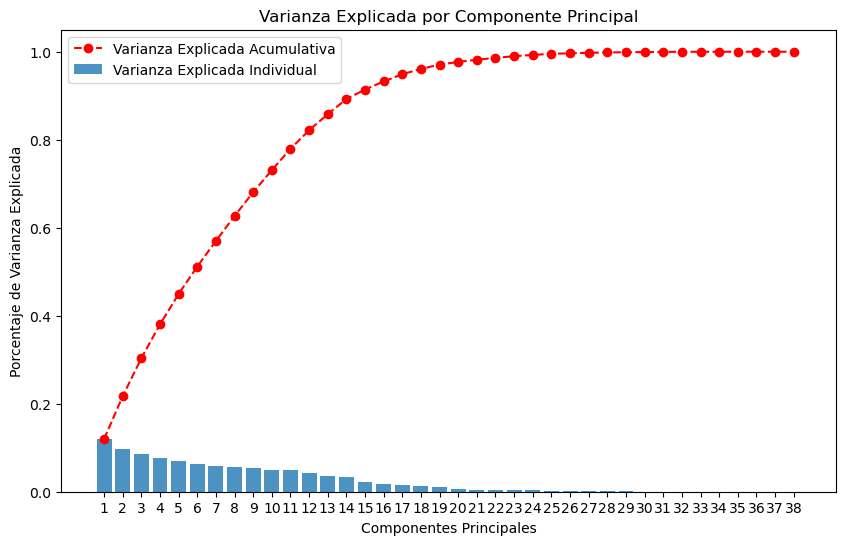

In [48]:
# Obtener los porcentajes de varianza explicada por cada componente principal
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

# Crear el barplot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, alpha=0.8, label='Varianza Explicada Individual')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, color='red', marker='o', linestyle='--', label='Varianza Explicada Acumulativa')
plt.xlabel('Componentes Principales')
plt.ylabel('Porcentaje de Varianza Explicada')
plt.title('Varianza Explicada por Componente Principal')
plt.xticks(range(1, len(variance_ratio) + 1))
plt.legend()
plt.show()

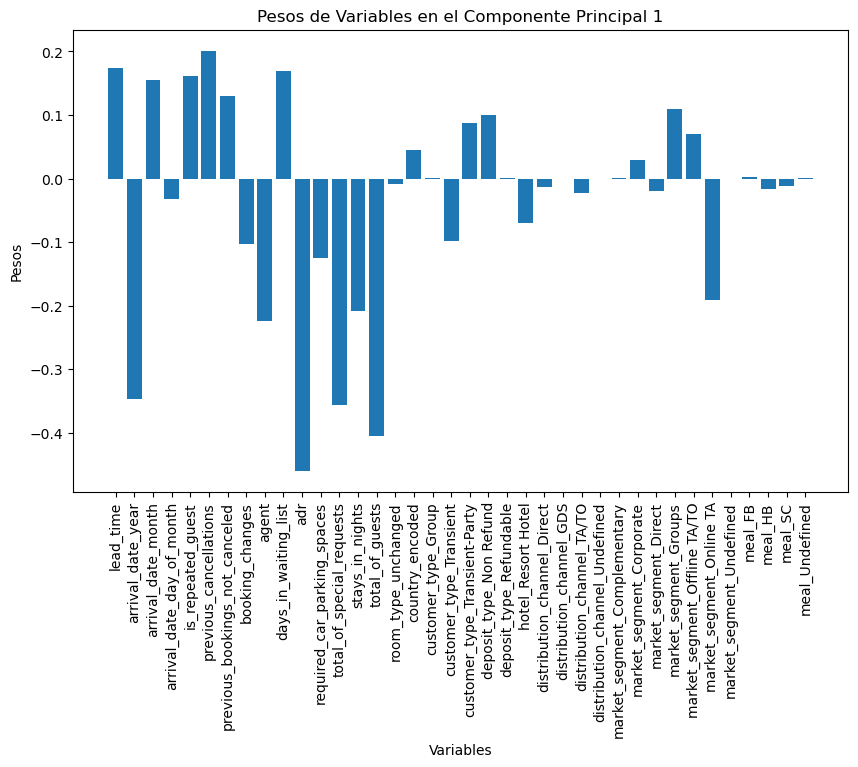

In [49]:
# Obtener los pesos de las variables en cada componente principal
component_weights = pca.components_

# Crear un gráfico de barras para mostrar los pesos
plt.figure(figsize=(10, 6))
plt.bar(range(len(component_weights[0])), component_weights[0])
plt.xlabel('Variables')
plt.ylabel('Pesos')
plt.title('Pesos de Variables en el Componente Principal 1')
plt.xticks(range(len(component_weights[0])), x_train_norm.columns, rotation='vertical')
plt.show()
# Si el peso de una variable es negativo en un componente, significa que hay una relación inversa entre esa variable y el componente
# Un peso negativo indica que a medida que el valor de la variable aumenta, el valor del componente principal correspondiente disminuye.

##### Modelo de clasificación con PCA: SVM en datos escalados y transformados

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      6033
           1       0.82      0.73      0.77      6138

    accuracy                           0.78     12171
   macro avg       0.78      0.78      0.78     12171
weighted avg       0.78      0.78      0.78     12171



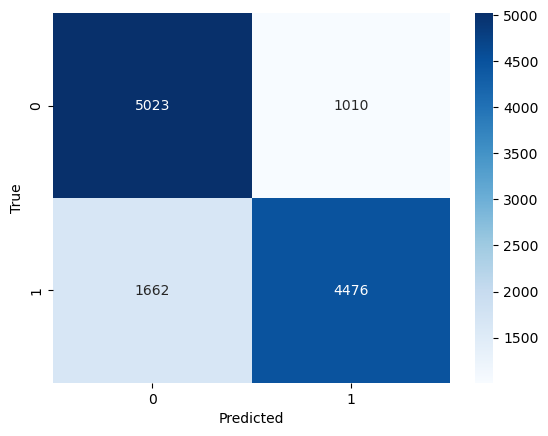

In [22]:
#Defino el tipo de escalado, la transformacion PCA y el modelo
_sc = StandardScaler()
_pca = PCA(componentes_deseados)
_model = SVC()

#Creo un pipeline
svm_model = Pipeline([
   # ('std_scaler', _sc), # No es necesario, los datos ya están escalados
    ('pca', _pca),
    ('svm', _model)
])

#Entreno sobre los datos que serán previamente escalados y transformados
svm_model.fit(x_train_norm,y_train)

#Hago la predicción y calculo las métricas
y_pred_pca=svm_model.predict(x_test_norm)
metricas(y_pred_pca,y_test)

In [26]:
accuracy_svm_pca = accuracy_score(y_test, y_pred_pca)*100
print('Se observa que para el ' + str(limite_varianza*100) + '% de varianza explicada, se necesitan ' + str(componentes_deseados) + ' componentes con una perdida de accuracy del ' + str(round(accuracy_svm_norm - accuracy_svm_pca,2)) + '%')

Se observa que para el 90.0% de varianza explicada, se necesitan 15 componentes con una perdida de accuracy del 6.43%


### SVM con kernel lineal

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      6033
           1       0.77      0.73      0.75      6138

    accuracy                           0.75     12171
   macro avg       0.75      0.75      0.75     12171
weighted avg       0.75      0.75      0.75     12171



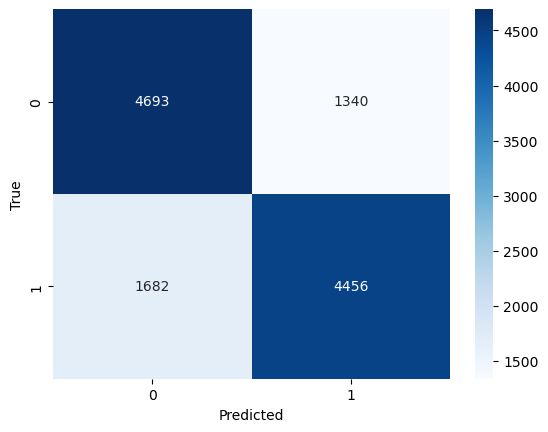

In [27]:
# Definir el modelo SVM con kernel lineal
_model = SVC(kernel='linear', C=1, random_state=42) # Kernel por defecto es 'rbf'

# Crear el pipeline con StandardScaler, PCA y el modelo SVM
svm_model = Pipeline([
    #('std_scaler', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('svm', _model)
])

# Entrenar el modelo SVM con el pipeline
svm_model.fit(x_train_norm, y_train)

# Hacer la predicción y calcular las métricas
y_pred = svm_model.predict(x_test_norm)
metricas(y_pred, y_test)

No se ve una mejora con respecto al modelo normalizado con StandardScaler y por los tiempos de entrenamiento, se decide no seguir probando con otros kernels.

---

## Aplicación del modelo al dataset de test

##### Lectura del dataset de test preprocesado:

In [19]:
hotel_test = pd.read_csv('./dataset/hotels_test_preprocesado.csv')

##### Lectura del dataset de test original para mantener id:

In [20]:
hotel_test_df = pd.read_csv('./dataset/hotels_test.csv')

##### Predicción y exportación:

In [37]:

x_test_final = hotel_test[features]
x_test_final_cat = x_test_final[cols_categorical].copy()
x_test_final_cat.columns = cols_categorical

x_test_final_norm = pd.DataFrame(data=stand_scaler.transform(x_test_final[cols_to_normalize].copy()))
x_test_final_norm.columns = cols_to_normalize

#Otra forma de obtener el dataframe con sus respectivas columnas es usar el metodo drop

In [39]:
y_pred_final = svm_norm.predict(pd.concat([x_test_final_norm, x_test_final_cat], axis=1))

In [50]:
counts = np.bincount(y_pred_final)
count_0 = counts[0]  # Cantidad de elementos 0
count_1 = counts[1]  # Cantidad de elementos 1

print("Resultado de la predicción: ")
print("No cancela:", count_0)
print("Cancela:", count_1)
print("Porceentaje de cancelaciones: {:.2f}%".format(count_1/(count_0+count_1)*100))

Resultado de la predicción: 
No cancela: 13349
Cancela: 13186
Porceentaje de cancelaciones: 49.69%


In [44]:
pd.concat([hotel_test_df['id'],pd.DataFrame(data=y_pred_final, columns=['is_canceled'])], axis=1).to_csv('./predicciones/pred_svm_norm.csv', index=False)

---

## Exportación del modelo

In [45]:
dump(svm_norm, open('./modelos/model_svm_norm.pkl', 'wb'))